<a href="https://colab.research.google.com/github/JacquelineGiPe/Bootcamp-DS-Proyecto-DS/blob/main/Actividad_VIII_Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Abstracto con Motivación y Audiencia**
## **Motivación**:
La tasa de suicidios es un problema de salud pública grave que afecta a nivel global. Analizar los factores asociados con las tasas de suicidio puede ayudar a identificar patrones y potencialmente prevenir futuros incidentes.

## **Audiencia:**
Los resultados de este análisis pueden ser útiles para:




*   Policymakers y autoridades de salud pública que buscan implementar programas de prevención.
*   Organizaciones no gubernamentales y entidades de salud mental que desean focalizar sus recursos.
*   Investigadores académicos interesados en la epidemiología del suicidio.



## **Preguntas/Problema que Buscamos Resolver**


**Problema Principal:**

 ¿Qué factores socioeconómicos y demográficos están más fuertemente asociados con las tasas de suicidio? Este problema se puede abordar como una tarea de regresión, donde nuestro objetivo es predecir la tasa de suicidios por 100,000 habitantes.


## **Análisis Exploratorio de Datos (EDA)**
Empezaremos con el análisis descriptivo de los datos, incluyendo visualizaciones y análisis de valores faltantes.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Cargar los datos
df = pd.read_csv('suicide_rates.csv')

# Mostrar información general del dataframe
print(df.info())

# Describir estadísticamente las variables numéricas
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5928 entries, 0 to 5927
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RegionCode                    5928 non-null   object 
 1   RegionName                    5928 non-null   object 
 2   CountryCode                   5928 non-null   object 
 3   CountryName                   5928 non-null   object 
 4   Year                          5928 non-null   int64  
 5   Sex                           5928 non-null   object 
 6   SuicideCount                  5928 non-null   int64  
 7   CauseSpecificDeathPercentage  5927 non-null   float64
 8   StdDeathRate                  5720 non-null   float64
 9   DeathRatePer100K              5720 non-null   float64
 10  Population                    5632 non-null   float64
 11  GDP                           5566 non-null   float64
 12  GDPPerCapita                  5566 non-null   float64
 13  GNI

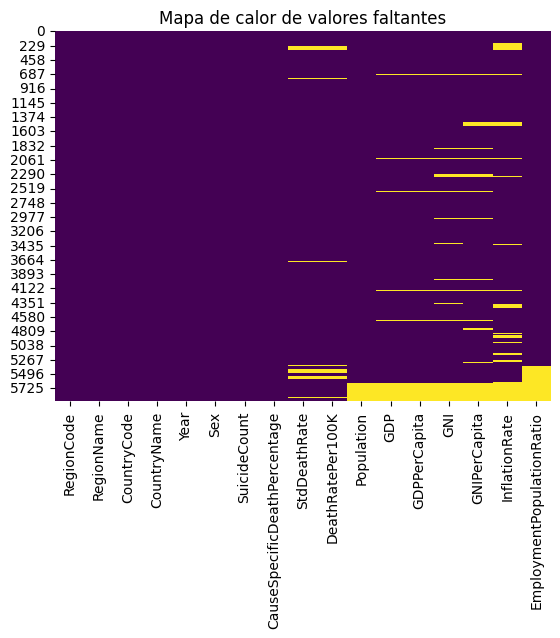

In [ ]:

# Visualización de valores faltantes
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores faltantes')
plt.show()

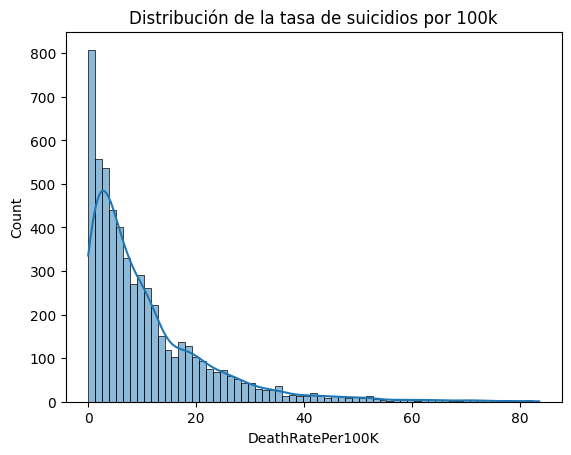

In [ ]:

# Visualizar la distribución de la variable objetivo (DeathRatePer100K)
sns.histplot(df['DeathRatePer100K'], kde=True)
plt.title('Distribución de la tasa de suicidios por 100k')
plt.show()

In [ ]:
# Creación de nuevas variables
df['SuicidesPer100K'] = (df['SuicideCount'] / df['Population']) * 100000
df['GDPtoGNI'] = df['GDPPerCapita'] / df['GNIPerCapita']

# Eliminación de filas con valores faltantes en la variable objetivo
df = df.dropna(subset=['DeathRatePer100K'])

# Separar características y variable objetivo
X = df.drop(columns=['DeathRatePer100K'])
y = df['DeathRatePer100K']

# Definir las columnas categóricas y numéricas
categorical_features = ['RegionCode', 'RegionName', 'CountryCode', 'CountryName', 'Sex']
numeric_features = ['Year', 'SuicideCount', 'CauseSpecificDeathPercentage', 'StdDeathRate',
                    'Population', 'GDP', 'GDPPerCapita', 'GNI', 'GNIPerCapita',
                    'InflationRate', 'EmploymentPopulationRatio', 'SuicidesPer100K', 'GDPtoGNI']

# Preprocesamiento de las variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Aplicar el preprocesamiento
X_processed = preprocessor.fit_transform(X)

# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Modelos a utilizar
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluar los modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} MSE: {mse}')

    # Validación cruzada
    scores = cross_val_score(model, X_processed, y, cv=5, scoring='neg_mean_squared_error')
    print(f'{name} CV MSE: {-scores.mean()}')

# Optimización de hiperparámetros para el modelo Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

Linear Regression MSE: 0.8910796350699838
Linear Regression CV MSE: 5.756395123888284
Random Forest MSE: 0.4008233525674791
Random Forest CV MSE: 5.472264290181103


In [ ]:

grid_search = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Mejor MSE: {-grid_search.best_score_}')
print(f'Mejor conjunto de parámetros: {grid_search.best_params_}')

# Selección del mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)

print(f'Best Model Test MSE: {final_mse}')


Mejor MSE: 0.3309749811701562
Mejor conjunto de parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Model Test MSE: 0.40766898004530683
